# Herschel Stripe 82 master catalogue
## Preparation of SDSS Stripe 82 data

This catalogue comes from `dmu0_SDSS-S82`.

In the catalogue, we keep:

- The `object_id` as unique object identifier;
- The position;
- The u, g, r, i, z, aperture magnitude (for now in 3”);
- The u, g, r, i, z, auto fluxes and magnitudes.


We don't know when the maps have been observed. We will use the year of the reference paper.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
3359e8e (Tue Jul 25 13:21:12 2017 +0100)


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates_tiled
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux

In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "sdss_ra"
DEC_COL = "sdss_dec"

## I - Column selection

In [4]:
imported_columns = OrderedDict({
        "objID": "sdss_id",
        "ra": "sdss_ra",
        "dec": "sdss_dec",
        "flags": "flags",
        "probPSF": "sdss_stellarity",
        "petroMag_u": "m_sdss_u",
        "petroMag_g": "m_sdss_g",
        "petroMag_r": "m_sdss_r",
        "petroMag_i": "m_sdss_i",
        "petroMag_z": "m_sdss_z",
        "petroMagErr_u": "merr_sdss_u",
        "petroMagErr_g": "merr_sdss_g",
        "petroMagErr_r": "merr_sdss_r",
        "petroMagErr_i": "merr_sdss_i",
        "petroMagErr_z": "merr_sdss_z",
        "fiberMag_u": "m_ap_sdss_u",
        "fiberMag_g": "m_ap_sdss_g",
        "fiberMag_r": "m_ap_sdss_r",
        "fiberMag_i": "m_ap_sdss_i",
        "fiberMag_z": "m_ap_sdss_z",
        "fiberMagErr_u": "merr_ap_sdss_u",
        "fiberMagErr_g": "merr_ap_sdss_g",
        "fiberMagErr_r": "merr_ap_sdss_r",
        "fiberMagErr_i": "merr_ap_sdss_i",
        "fiberMagErr_z": "merr_ap_sdss_z"        
    })


catalogue = Table.read(
    "../../dmu0/dmu0_SDSS-S82/data/SDSS-S82_HELP-coverage.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2013

# Clean table metadata
catalogue.meta = None

### I.a - Flag selection

The SDSS-S82 catalogue contains a lot of spurious sources. We use the content of the `flags` column to select reliable sources using the prescriptions given on [this page](http://skyserver.sdss.org/dr7/en/help/docs/algorithm.asp?key=flags).

In [5]:
# Dictionnary of the integer value associated to each flag value
flag = {
 'AMOMENT_FAINT': 9007199254740992,
 'AMOMENT_MAXITER': 36028797018963968,
 'AMOMENT_SHIFT': 18014398509481984,
 'BADSKY': 4194304,
 'BAD_COUNTS_ERROR': 1099511627776,
 'BAD_MOVING_FIT': 34359738368,
 'BAD_MOVING_FIT_CHILD': 2199023255552,
 'BAD_RADIAL': 32768,
 'BINNED1': 268435456,
 'BINNED2': 536870912,
 'BINNED4': 1073741824,
 'BLENDED': 8,
 'BRIGHT': 2,
 'BRIGHTEST_GALAXY_CHILD': 2251799813685248,
 'CANONICAL_BAND': 4503599627370496,
 'CANONICAL_CENTER': 1,
 'CENTER_OFF_AIMAGE': 562949953421312,
 'CHILD': 16,
 'COSMIC_RAY': 4096,
 'DEBLENDED_AS_MOVING': 4294967296,
 'DEBLENDED_AS_PSF': 33554432,
 'DEBLENDED_AT_EDGE': 35184372088832,
 'DEBLEND_DEGENERATE': 1125899906842624,
 'DEBLEND_NOPEAK': 70368744177664,
 'DEBLEND_PRUNED': 67108864,
 'DEBLEND_TOO_MANY_PEAKS': 2048,
 'DEBLEND_UNASSIGNED_FLUX': 4398046511104,
 'EDGE': 4,
 'ELLIPFAINT': 134217728,
 'GROWN_MERGED': 2305843009213693952,
 'HAS_CENTER': 4611686018427387904,
 'INCOMPLETE_PROFILE': 65536,
 'INTERP': 131072,
 'INTERP_CENTER': 17592186044416,
 'LOCAL_EDGE': 549755813888,
 'MANYPETRO': 512,
 'MANYR50': 8192,
 'MANYR90': 16384,
 'MAYBE_CR': 72057594037927936,
 'MAYBE_EGHOST': 144115188075855872,
 'MEDIAN_CENTER': 274877906944,
 'MOVED': 2147483648,
 'NODEBLEND': 64,
 'NODEBLEND_MOVING': 8589934592,
 'NOPETRO': 256,
 'NOPETRO_BIG': 1024,
 'NOPROFILE': 128,
 'NOSTOKES': 2097152,
 'NOTCHECKED': 524288,
 'NOTCHECKED_CENTER': 288230376151711744,
 'OBJECT2_DEBLEND_PEEPHOLE': 1152921504606846976,
 'OBJECT2_HAS_SATUR_DN': 576460752303423488,
 'PEAKCENTER': 32,
 'PEAKS_TOO_CLOSE': 137438953472,
 'PETROFAINT': 8388608,
 'PSF_FLUX_INTERP': 140737488355328,
 'SATURATED': 262144,
 'SATUR_CENTER': 8796093022208,
 'STATIONARY': 68719476736,
 'SUBTRACTED': 1048576,
 'TOO_FEW_DETECTIONS': 17179869184,
 'TOO_FEW_GOOD_DETECTIONS': 281474976710656,
 'TOO_LARGE': 16777216
}

# Flag defined in the prescription page (we don't have the psfErr column
# so we don't use its value)
flag['DEBLEND_PROBLEMS'] = flag['PEAKCENTER'] | flag['NOTCHECKED']

In [6]:
sdss_flags = catalogue['flags']

to_keep = np.full(len(catalogue), True, dtype=bool)

to_keep &= (sdss_flags & flag['BINNED1']).astype(bool)
#to_keep &= ~(sdss_flags & flag['BRIGHT']).astype(bool)  # We keep bright sources as we want all the sources
to_keep &= (~(sdss_flags & flag['BLENDED']).astype(bool) | (sdss_flags & flag['NODEBLEND']).astype(bool))
to_keep &= ~(sdss_flags & flag['SATURATED']).astype(bool)
to_keep &= ~(sdss_flags & flag['NOPROFILE']).astype(bool)
#to_keep &= ~(sdss_flags & flag['EDGE']).astype(bool)
to_keep &= ~(sdss_flags & flag['DEBLEND_PROBLEMS']).astype(bool)

In [7]:
print("Full catalogue: {} sources".format(len(catalogue)))

catalogue = catalogue[to_keep]

print("Flag cleaned catalogue: {} sources".format(len(catalogue)))

Full catalogue: 183845668 sources
Flag cleaned catalogue: 168624210 sources


In [8]:
# Adding flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('m_'):
        
        errcol = "merr{}".format(col[1:])
        flux, error = mag_to_flux(np.array(catalogue[col]), np.array(catalogue[errcol]))
        
        # Fluxes are added in µJy
        catalogue.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        catalogue.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))
        
        # Band-flag column
        if 'ap' not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        


/home/yroehlly/herschelhelp_internal/herschelhelp_internal/utils.py:39: RuntimeWarning: overflow encountered in power
  fluxes = 10 ** ((8.9 - magnitudes)/2.5)


In [9]:
catalogue[:10].show_in_notebook()

idx,sdss_id,sdss_ra,sdss_dec,flags,sdss_stellarity,m_sdss_u,m_sdss_g,m_sdss_r,m_sdss_i,m_sdss_z,merr_sdss_u,merr_sdss_g,merr_sdss_r,merr_sdss_i,merr_sdss_z,m_ap_sdss_u,m_ap_sdss_g,m_ap_sdss_r,m_ap_sdss_i,m_ap_sdss_z,merr_ap_sdss_u,merr_ap_sdss_g,merr_ap_sdss_r,merr_ap_sdss_i,merr_ap_sdss_z,f_sdss_u,ferr_sdss_u,flag_sdss_u,f_sdss_g,ferr_sdss_g,flag_sdss_g,f_sdss_r,ferr_sdss_r,flag_sdss_r,f_sdss_i,ferr_sdss_i,flag_sdss_i,f_sdss_z,ferr_sdss_z,flag_sdss_z,f_ap_sdss_u,ferr_ap_sdss_u,f_ap_sdss_g,ferr_ap_sdss_g,f_ap_sdss_r,ferr_ap_sdss_r,f_ap_sdss_i,ferr_ap_sdss_i,f_ap_sdss_z,ferr_ap_sdss_z
0,8647474690330264163,350.450263283,-1.10048099272,70437765645072,1.0,27.8637,27.6108,25.2144,23.2329,22.471,3.67081,5.43418,0.6419,0.194392,0.288635,28.5033,28.7316,25.3251,23.507,22.7375,2.49623,5.13675,0.665813,0.207864,0.334695,0.0259734,0.0878145,False,0.0327856,0.164094,False,0.298005,0.176184,False,1.84854,0.330966,False,3.72921,0.991385,False,0.014411,0.0331324,0.0116776,0.0552484,0.269119,0.165034,1.43608,0.274938,2.91734,0.899317
1,8647474690330264174,350.449625855,-1.11064225609,34628173824,1.0,24.3054,21.4901,19.9529,19.2967,18.8906,0.660506,0.0316026,0.00871022,0.00777683,0.0171183,26.0638,21.7857,20.2664,19.6031,19.2025,1.81396,0.0244528,0.00693806,0.00614046,0.0135727,0.688405,0.41879,False,9.2033,0.267881,False,37.916,0.304177,False,69.396,0.497065,False,100.866,1.59031,False,0.136289,0.2277,7.01014,0.157881,28.4073,0.181528,52.3305,0.295959,75.6812,0.946081
2,8647474690330527499,351.04211404,-1.05477507988,68987912448,0.0,24.0891,23.227,22.4613,21.9686,21.4731,0.566811,0.160892,0.0871699,0.0894345,0.202788,24.3611,23.5755,22.7428,22.3586,22.185,0.405385,0.124811,0.063816,0.0720987,0.202787,0.840156,0.438605,False,1.85861,0.275422,False,3.76269,0.302093,False,5.92347,0.487929,False,9.34903,1.74616,False,0.65399,0.244182,1.34834,0.154999,2.90327,0.170645,4.13565,0.274629,4.85308,0.906427
3,8647474690330527500,351.04250754,-1.20135425511,68987912192,0.0,30.1262,23.0198,22.2378,21.471,21.4561,2.15468,0.156382,0.086766,0.0761362,0.21743,24.6922,23.4019,22.5381,22.0618,21.8795,0.548303,0.106458,0.0529852,0.0550035,0.153282,0.0032325,0.006415,False,2.24946,0.323997,False,4.62262,0.369414,False,9.36741,0.65688,False,9.49608,1.90169,False,0.482064,0.243445,1.58213,0.155131,3.50561,0.171078,5.43603,0.27539,6.42994,0.907764
4,8647474690330527502,351.042071098,-1.16249261287,70437732090640,1.0,24.8637,25.8082,24.4078,22.3283,21.1924,0.842675,1.37937,0.510426,0.131096,0.129385,25.1781,24.6649,23.6675,22.2888,21.3138,0.849388,0.360842,0.197442,0.0901252,0.102344,0.411633,0.319482,False,0.172467,0.219109,False,0.626417,0.294491,False,4.253,0.513524,False,12.1066,1.44272,False,0.308138,0.241061,0.494345,0.164294,1.23876,0.22527,4.41038,0.366099,10.826,1.02048
5,8647474690330527503,351.042573054,-1.16272098506,70437732090456,0.0,24.0778,24.6829,23.044,22.1763,22.6825,1.03229,1.21688,0.314667,0.330181,1.44851,25.3009,23.9522,23.2106,22.4364,21.8593,0.947552,0.179624,0.108491,0.131731,0.220472,0.848916,0.807125,False,0.486241,0.544972,False,2.19982,0.63755,False,4.892,1.4877,False,3.06888,4.09429,False,0.275187,0.240163,0.953044,0.157671,1.88698,0.188554,3.84984,0.467095,6.55055,1.33017
6,8647474690330527504,351.042263786,-1.11364617453,281543964622848,0.0,24.341,24.3977,31.83,27.1244,23.7247,1.14814,0.79854,0.400453,11.3532,2.57289,24.7522,24.3631,24.7733,24.2462,23.2522,0.57821,0.256989,0.409109,0.406026,0.538063,0.666167,0.704458,False,0.632302,0.465047,False,0.000672947,0.000248203,False,0.0513163,0.536599,False,1.17525,2.785,False,0.456179,0.242939,0.652781,0.15451,0.447364,0.168569,0.726983,0.271865,1.81602,0.899974
7,8647474690330527441,351.032278869,-1.12234580217,68987912448,0.0,23.3213,22.7152,22.1108,21.6041,21.9389,0.645525,0.254745,0.109711,0.144244,0.664385,24.5026,23.7439,22.9301,22.4731,22.2444,0.460955,0.145618,0.0757141,0.0800538,0.214101,1.70399,1.01311,False,2.97805,0.698737,False,5.19625,0.525067,False,8.28644,1.10088,False,6.08

## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [10]:
import logging
logging.basicConfig(level=logging.INFO)

In [11]:
SORT_COLS = []
FLAG_NAME = 'sdss_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates_tiled(
    catalogue, RA_COL, DEC_COL, 
    sort_col= SORT_COLS,
    flag_name=FLAG_NAME,
    near_ra0=True)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

INFO:herschelhelp_internal.masterlist:The catalogue is divided in 47 x 3 (RA, Dec) tiles
INFO:herschelhelp_internal.masterlist:Processing RA between -9.925090 and -8.925090, and Dec between -1.282642 and -0.282642
/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)
INFO:herschelhelp_internal.masterlist:Processing RA between -9.925090 and -8.925090, and Dec between -0.282642 and 0.717358
INFO:herschelhelp_internal.masterlist:Processing RA between -9.925090 and -8.925090, and Dec between 0.717358 and 1.717358
INFO:herschelhelp_internal.masterlist:Processing RA between -8.925090 and -7.925090, and Dec between -1.282642 and -0.282642
INFO:herschelhelp_internal.masterlist:Processi

The initial catalogue had 168624210 sources.
The cleaned catalogue has 30221024 sources (138403186 removed).
The cleaned catalogue has 6003372 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [13]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_Herschel-Stripe-82.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

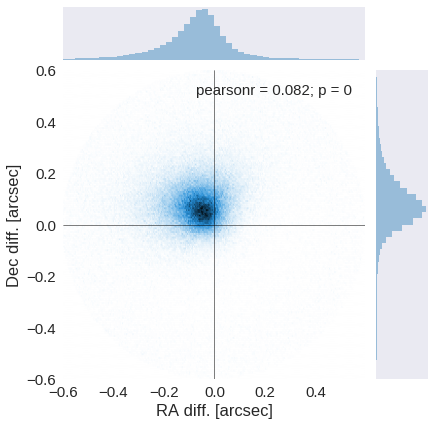

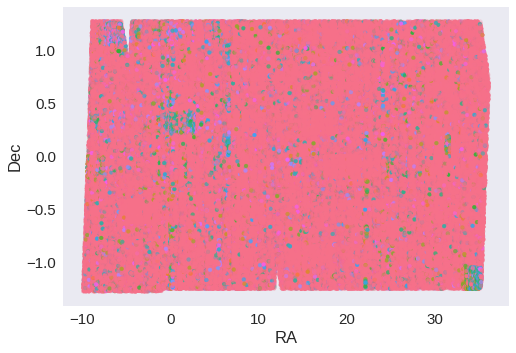

In [14]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec, near_ra0=True)

In [15]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords, near_ra0=True
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: 0.06178280046924556 arcsec
Dec correction: -0.07313427860226596 arcsec


In [16]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

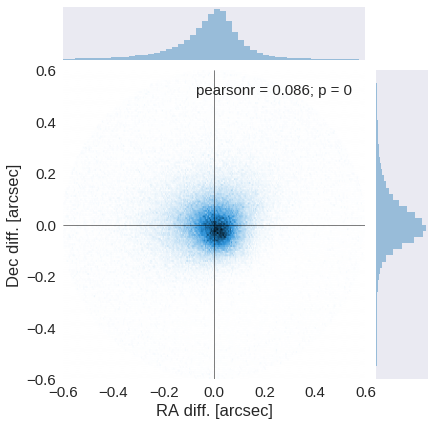

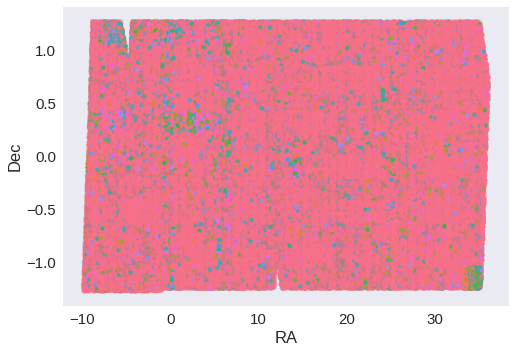

In [17]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec, near_ra0=True)

## IV - Flagging Gaia objects

In [18]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [19]:
GAIA_FLAG_NAME = "sdss_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

365534 sources flagged.


## V - Flagging objects near bright stars

# VI - Saving to disk

In [20]:
catalogue.write("{}/SDSS-S82.fits".format(OUT_DIR), overwrite=True)